In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [70]:
# Load the dataset
data = load_diabetes()
X = data.data
y = data.target

In [71]:
# Initial split to separate out the test set (e.g., 20% of the data)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split the remaining data into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)
# Note: 0.25 * 0.8 = 0.2, so the validation set is 20% of the original data.

# Standardize the features using the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val = scaler.transform(X_val)          # Only transform on validation data
X_test = scaler.transform(X_test)        # Only transform on test data

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [72]:
# 2. Define the neural network model
class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 1)  # Output layer for regression

    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.layer2(out)
        return out

model = DiabetesModel()

In [73]:
# 3. Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop with training and validation loss tracking
num_epochs = 1500

# Define lists to store training and validation losses
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item() * inputs.size(0)
    
    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)

    # Calculate average validation loss for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Print losses every few epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Training Loss: {epoch_train_loss:.4f} '
              f'Validation Loss: {epoch_val_loss:.4f}')



Epoch [1/1500] Training Loss: 28586.4691 Validation Loss: 32702.9091
Epoch [10/1500] Training Loss: 27814.8140 Validation Loss: 31823.3668
Epoch [20/1500] Training Loss: 25916.1843 Validation Loss: 29602.6466
Epoch [30/1500] Training Loss: 22444.7499 Validation Loss: 25605.2146
Epoch [40/1500] Training Loss: 17897.6590 Validation Loss: 20349.8511
Epoch [50/1500] Training Loss: 13517.6999 Validation Loss: 15201.3243
Epoch [60/1500] Training Loss: 10115.2388 Validation Loss: 11225.9810
Epoch [70/1500] Training Loss: 7885.6672 Validation Loss: 8617.8847
Epoch [80/1500] Training Loss: 6574.3353 Validation Loss: 7167.0684
Epoch [90/1500] Training Loss: 5759.3490 Validation Loss: 6353.4572
Epoch [100/1500] Training Loss: 5245.4039 Validation Loss: 5850.8316
Epoch [110/1500] Training Loss: 4899.1353 Validation Loss: 5501.4274
Epoch [120/1500] Training Loss: 4621.9713 Validation Loss: 5245.9429
Epoch [130/1500] Training Loss: 4393.3566 Validation Loss: 4988.9951
Epoch [140/1500] Training Loss:

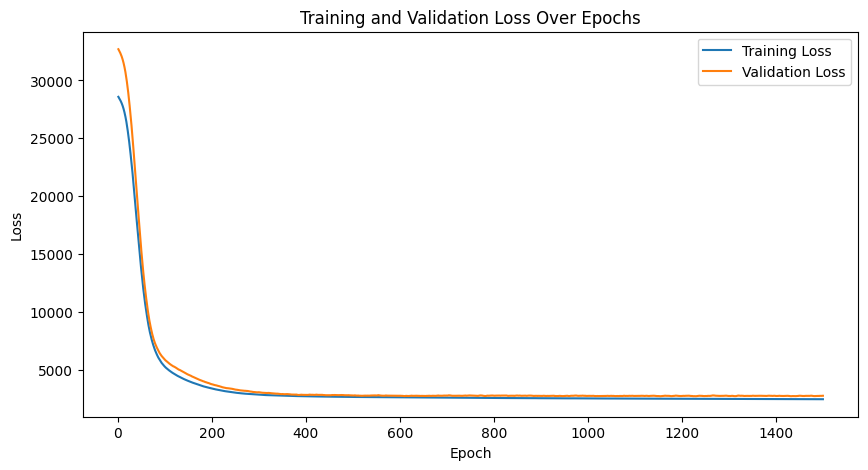

In [74]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [75]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Evaluate on the test data
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor).item()
    test_mse = mean_squared_error(y_test_tensor.numpy(), test_outputs.numpy())

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Test Loss: 2782.5264
Test MSE: 2782.5261
